IMPORTING LIBRARIES

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.layers import Conv2D,AveragePooling2D,Dropout,Flatten,Dense,BatchNormalization,InputLayer,MaxPooling2D
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model,Sequential,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2
from google.colab.patches import cv2_imshow      #cv2.imshow() not working in colab 

In [ ]:
#DEALING WIYH COMMAND PROMPT USING ARGPARSE LIB(USED IN .PY FILE)

# ap=argparse.ArgumentParser()
# # The path to the input dataset of faces and and faces with masks
# ap.add_argument("-d","--dataset",required=True,help="path to input dataset")
# # The path to your output training history plot, which will be generated using matplotlib
# ap.add_argument("-p","--plot",type=str,default="/home/neha/Downloads/Projects/face-mask-detector-master/plot.png",help="path to output loss/accuracy plot")
# # The path to the resulting serialized face mask classification model
# ap.add_argument("-m","--model",type=str,default="/home/neha/Downloads/Projects/face-mask-detector-master/mask_detection_model",help="path to output face mask detector model")
# args=vars(ap.parse_args())

In [ ]:
#batch size
BS=64

In [ ]:
#dataset path
path='/content/drive/My Drive/Projects/FaceMask detection/dataset'

In [ ]:
print('number of classes {} and they are 0:{},1:{}'.format(len(os.listdir(path)),os.listdir(path)[0],os.listdir(path)[1]))
print('number of images with mask:{}, number of images without mask:{}'.format(len(os.listdir(path+'/'+os.listdir(path)[0])),len(os.listdir(path+'/'+os.listdir(path)[1]))))

number of classes 2 and they are 0:with_mask,1:without_mask
number of images with mask:690, number of images without mask:686


In [ ]:
image=img_to_array(load_img('/content/drive/My Drive/Projects/FaceMask detection/dataset/with_mask/0-with-mask.jpg'))
image.shape

(350, 525, 3)

PREPARING INPUT DATA AND TARGET DATA

In [ ]:
imagePaths=glob.glob(path+'/*')  
imagePaths
data=[]
labels=[]

for imagePath in imagePaths:
  for imagep in glob.glob(imagePath+'/*.jpg'): 
  #load the input image and preprocess it
    image=load_img(imagep,target_size=(150,150))
    image=img_to_array(image)
    image=preprocess_input(image)
  #extract class label 
    label=imagep.split('/')[-2]
  #update data and label list
    data.append(image)
    labels.append(label)

# convert the data and labels to NumPy arrays
data1 = np.array(data, dtype="float32")
labels1 = np.array(labels)

In [ ]:
#perform one hot encoding on the labels
lb=LabelBinarizer()
labels=lb.fit_transform(labels1)  #REQUIRES NUMPY ARRAY
labels=to_categorical(labels)

# partition the data into training and testing splits using 80% of the data for training and the remaining 20% for testing
(trainX,testX,trainY,testY)=train_test_split(data1,labels,test_size=0.2,stratify=labels,random_state=42) 

#construct training image generator for data augmentation
aug=ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

DEFINING MODEL

In [ ]:
model=Sequential()
model.add(InputLayer(input_shape=(150,150,3)))                                  #(150,150,3)
model.add(Conv2D(32,(9,9),activation='tanh'))                                   #(142,142,32)
model.add(BatchNormalization(axis=-1))
model.add(AveragePooling2D(pool_size= (3,3)))                                   #(47,47,32)
model.add(Conv2D(32,(5,5),activation='tanh'))                                   #(43,43,32)
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(64,(5,5),activation='tanh'))                                   #(39,39,64)
model.add(BatchNormalization(axis=-1))                         
model.add(Conv2D(64,(5,5),activation='tanh'))                                   #(35,35,64)
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size= (2,2)))                                       #(17,17,64)
model.add(Conv2D(128,(3,3),activation='relu'))                                  #(15,15,128)
model.add(BatchNormalization(axis=-1))
model.add(MaxPooling2D(pool_size= (2,2)))                                       #(7,7,256)
model.add(Conv2D(256,(3,3),activation='relu'))                                  #(5,5,256)
model.add(BatchNormalization(axis=-1))
model.add(Conv2D(256,(5,5),activation='relu'))                                  #(1,1,256)

model.add(Flatten())                                                             #(256,)

#Regularization layers
model.add(Dense(units=128,kernel_regularizer=regularizers.l1_l2(l1=1e-5,l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5),activation='relu'))   #(128,)

#Regularization layers
model.add(Dense(units=32,kernel_regularizer=regularizers.l1_l2(l1=1e-5,l2=1e-4),
                bias_regularizer=regularizers.l2(1e-4),
                activity_regularizer=regularizers.l2(1e-5),activation='relu'))   #(32,) 

#The Final layer with two outputs for two categories   
model.add(Dense(2,activation='softmax'))                                         #(2,)

ARCHITECTURE OF MODEL

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 142, 142, 32)      7808      
_________________________________________________________________
batch_normalization (BatchNo (None, 142, 142, 32)      128       
_________________________________________________________________
average_pooling2d (AveragePo (None, 47, 47, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 43, 43, 32)        25632     
_________________________________________________________________
batch_normalization_1 (Batch (None, 43, 43, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 39, 64)        51264     
_________________________________________________________________
batch_normalization_2 (Batch (None, 39, 39, 64)        2

COMPILING AND TRAINING THE MODEL

In [ ]:
#FOR STORING CHECKPOINT

# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# checkpoint = ModelCheckpoint('model-{epoch:03d}.model',monitor='val_loss',verbose=0,save_best_only=True, mode='auto')
# history=model.fit(train_data, train_target, epochs=15, callbacks=[checkpoint], validation_split=0.2)

In [ ]:
EPOCHS=20

#compiling model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])   #DEFAULT LEARNING RATE OF ADAM IS 0.001

#fitting (training) model
BODY_model=model.fit(
    aug.flow(trainX,trainY,batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX,testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS)


Epoch 1/20
17/17 [==============================] - 5s 319ms/step - loss: 0.4576 - accuracy: 0.8764 - val_loss: 1.4094 - val_accuracy: 0.5616
Epoch 2/20
17/17 [==============================] - 5s 309ms/step - loss: 0.3255 - accuracy: 0.9219 - val_loss: 1.2755 - val_accuracy: 0.6159
Epoch 3/20
17/17 [==============================] - 5s 291ms/step - loss: 0.2475 - accuracy: 0.9382 - val_loss: 2.0874 - val_accuracy: 0.5000
Epoch 4/20
17/17 [==============================] - 5s 290ms/step - loss: 0.2783 - accuracy: 0.9228 - val_loss: 5.0247 - val_accuracy: 0.5072
Epoch 5/20
17/17 [==============================] - 5s 306ms/step - loss: 0.2657 - accuracy: 0.9384 - val_loss: 2.2856 - val_accuracy: 0.5652
Epoch 6/20
17/17 [==============================] - 5s 292ms/step - loss: 0.2223 - accuracy: 0.9411 - val_loss: 3.1138 - val_accuracy: 0.4928
Epoch 7/20
17/17 [==============================] - 5s 291ms/step - loss: 0.2223 - accuracy: 0.9353 - val_loss: 0.1295 - val_accuracy: 0.9783
Epoch 

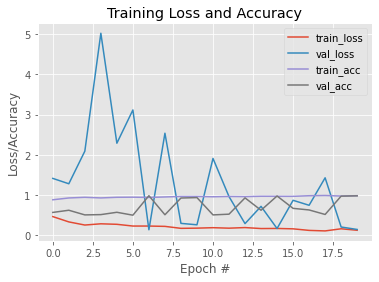

In [ ]:
# plot the training,validation loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), BODY_model.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), BODY_model.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), BODY_model.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), BODY_model.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc='best')

PREDICTION ON TEST SET AND ACCURACY(**F1-SCORE**)

In [ ]:
# make predictions on the testing set
predIdxs=model.predict(testX,batch_size=BS)

# for each image in the testing set we need to find the index of the label with corresponding largest predicted probability
predIdxs=np.argmax(predIdxs,axis=1)

#show nicely formatted classification report
print(classification_report(testY.argmax(axis=1),predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.97      0.97       138
without_mask       0.97      0.98      0.97       138

    accuracy                           0.97       276
   macro avg       0.97      0.97      0.97       276
weighted avg       0.97      0.97      0.97       276



SAVING THE MODEL TO DESIRED LOCATION

In [ ]:
model.save('/content/drive/My Drive/Projects/FaceMask detection/mask_detection_model_10_150',save_format='h5')

CHECKING PERFORMANCE OF MODEL ON IMAGES

In [ ]:
def detect_facemask(faces,face,model):
  if faces==():          #if no face is detected will feed whole image to model for prediction
    input_face=face
    input_face=cv2.resize(input_face,(150,150))
    input_face=img_to_array(input_face)
    input_face=preprocess_input(input_face)
    input_face=np.expand_dims(input_face,axis=0)
    (mask, withoutMask) = model.predict(input_face)[0]
    label="MASK" if mask>withoutMask else "No Mask"
    print(label+' IS DETECTED WITH {} ACCURACY'.format(max(mask,withoutMask)*100))

  else:                    #if face is detected then only detected face part is fed to model
    for (x,y,w,h) in faces:
      if (y<20 or y+h>140):
        Y=y
        Y_H=y+h
        X=x
        X_W=x+w
      else:
        Y=y-20
        Y_H=y+h+10
        X=x
        X_W=x+w
      input_face=face[Y:Y_H,X:X_W]       #Cropping detected face part of image
      input_face=cv2.resize(input_face,(150,150))
      input_face=img_to_array(input_face)
      input_face=preprocess_input(input_face)
      input_face=np.expand_dims(input_face,axis=0)
      (mask, withoutMask) = model.predict(input_face)[0]
      label="Mask" if mask>withoutMask else "No Mask"
      color=(0,255,0) if label =="Mask" else (0,0,255)
      label="{}:{:.2f}%".format(label,max(mask,withoutMask)*100)
      cv2.putText(face,label,(X,Y-10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
      cv2.rectangle(face,(X,Y),(X_W,Y_H),color,2)

  cv2_imshow(face)

In [ ]:
def test_image(path,model):
  #reading image
  face=cv2.imread(path)
  face=cv2.resize(face,(350,350))               
  gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
  #apply face detector on gray scaled version of image
  faces = face_cascade.detectMultiScale(gray, 1.3, 1,flags=0,minSize=(65,65))   
  detect_facemask(faces,face,model)

[MODEL_LINK](https://drive.google.com/file/d/1-FsgDjt_yypY1WO8Ii8KJKPP2s7ZINlJ/view?usp=sharing)

In [ ]:
#loading saved model
model=load_model('/content/drive/My Drive/Projects/FaceMask detection/mask_detection_model_10_150')

#usimg xml file for face detection using haar cascading
face_cascade = cv2.CascadeClassifier('/content/drive/My Drive/Projects/FaceMask detection/haarcascade_frontalface_default.xml')

TEST MODEL ON DATASET

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


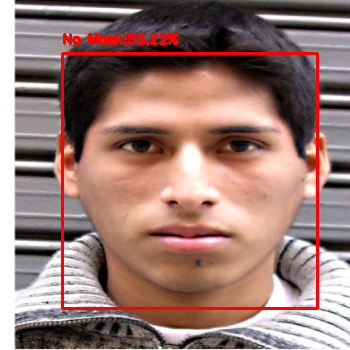

In [ ]:
test_image('/content/drive/My Drive/Projects/FaceMask detection/dataset/without_mask/158.jpg',model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


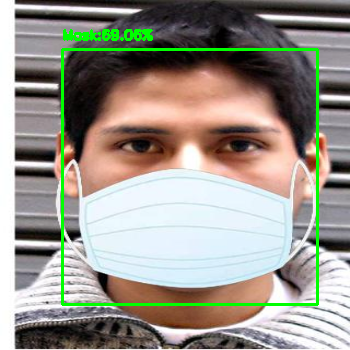

In [ ]:
test_image('/content/drive/My Drive/Projects/FaceMask detection/dataset/with_mask/158-with-mask.jpg',model)

MOST OF THE FACES WITH-MASK IMAGES ARE NOT DETECTED BY **FACE DETECTION         HAAR-CASCADE MODEL** AS MODEL IS NOT SPECIFICALLY TRAINED ON FACES WITH-MASK.AS A RESULT MODEL FACES PROBLEM IN DETECTING FACES-WITH-MASK SO WHOLE IMAGE IS FED TO FACE_MASK_DETECTOR MODEL

MASK IS DETECTED WITH 57.19631910324097 ACCURACY


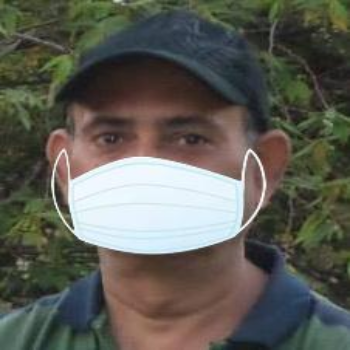

In [ ]:
test_image('/content/drive/My Drive/Projects/FaceMask detection/dataset/with_mask/154-with-mask.jpg',model)

In [ ]:
labels=model.predict_classes(testX[:3])
labels

array([0, 0, 1])

0:WITH_MASK,1:WITHOUT_MASK

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


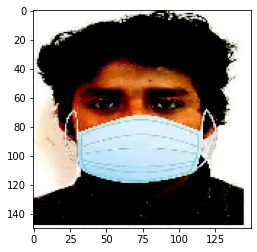

In [ ]:
plt.imshow(testX[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


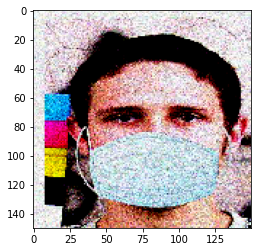

In [ ]:
plt.imshow(testX[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


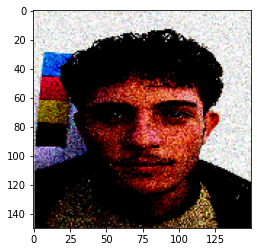

In [ ]:
plt.imshow(testX[2])

LETS TEST ON SOME UNSEEN IMAGES FROM CHROME

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


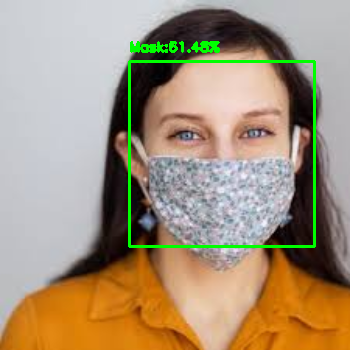

In [ ]:
test_image('/content/drive/My Drive/Projects/FaceMask detection/img1.jpeg',model)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  


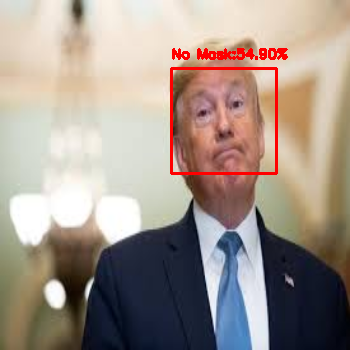

In [ ]:
test_image('/content/drive/My Drive/Projects/FaceMask detection/img4 (1).jpeg',model)

CHECKING PERFORMANCE OF MODEL ON LIVEFEED VIDEO

In [ ]:
cap = cv2.VideoCapture(0)     #starts webcame and captures video

while cap.isOpened():
	ret, face = cap.read()           #for each frame
	face=cv2.flip(face,1)            #flips the frame
	face=cv2.resize(face,(350,350))
	gray = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
	gray = cv2.equalizeHist(gray)     #apply histogram equlization on image and enhance proper distribution of pixel intensities as in live feed image is not equalized properly
	faces = face_cascade.detectMultiScale(gray, 1.3, 1,flags=0,minSize=(65,65))
	
	if faces==():                        #if no face is detected will feed whole image to model for prediction
		input_face=face
		input_face=cv2.resize(input_face,(150,150))
		input_face=img_to_array(input_face)
		input_face=preprocess_input(input_face)
		input_face=np.expand_dims(input_face,axis=0)
		(mask, withoutMask) = new_model.predict(input_face)[0]
		label="Mask" if mask>withoutMask else "No Mask"
		color=(0,255,0) if label =="Mask" else (0,0,255)
		label="{}:{:.2f}%".format(label,max(mask,withoutMask)*100)
		cv2.putText(face,label,(30,30),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)

	else:                                 #if face is detected then only detected face part is fed to model
		for (x,y,w,h) in faces:
			if (y<20 or y+h>140):
				Y=y
				Y_H=y+h
				X=x
				X_W=x+w
			else:
				Y=y-20
				Y_H=y+h+10
				X=x
				X_W=x+w 
			input_face=face[Y:Y_H,X:X_W]        #Cropping detected face part of image
			input_face=cv2.resize(input_face,(150,150))
			input_face=img_to_array(input_face)
			input_face=preprocess_input(input_face)
			input_face=np.expand_dims(input_face,axis=0)
			(mask, withoutMask) = new_model.predict(input_face)[0]
			label="Mask" if mask>withoutMask else "No Mask"
			#print(label)
			color=(0,255,0) if label =="Mask" else (0,0,255)
			label="{}:{:.2f}%".format(label,max(mask,withoutMask)*100)
			cv2.putText(face,label,(X,Y-10),cv2.FONT_HERSHEY_SIMPLEX, 0.45, color, 2)
			cv2.rectangle(face,(X,Y),(X_W,Y_H),color,2)

	cv2.imshow('img',face)
	k = cv2.waitKey(100) & 0xff      #waits for 0.1 sec for next frame
	if k == 27:                      #'Esc' key exits the programme
		break

[faceMask detection on live feed](https://drive.google.com/file/d/1wasTJE8agMuQ3arY_YKGdrcz2L-YZjcY/view?usp=sharing)